# Модуль 4. **Класифікація та оцінка роботи моделі**

# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [769]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [770]:
df = pd.read_csv("bikes_rent.csv")
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

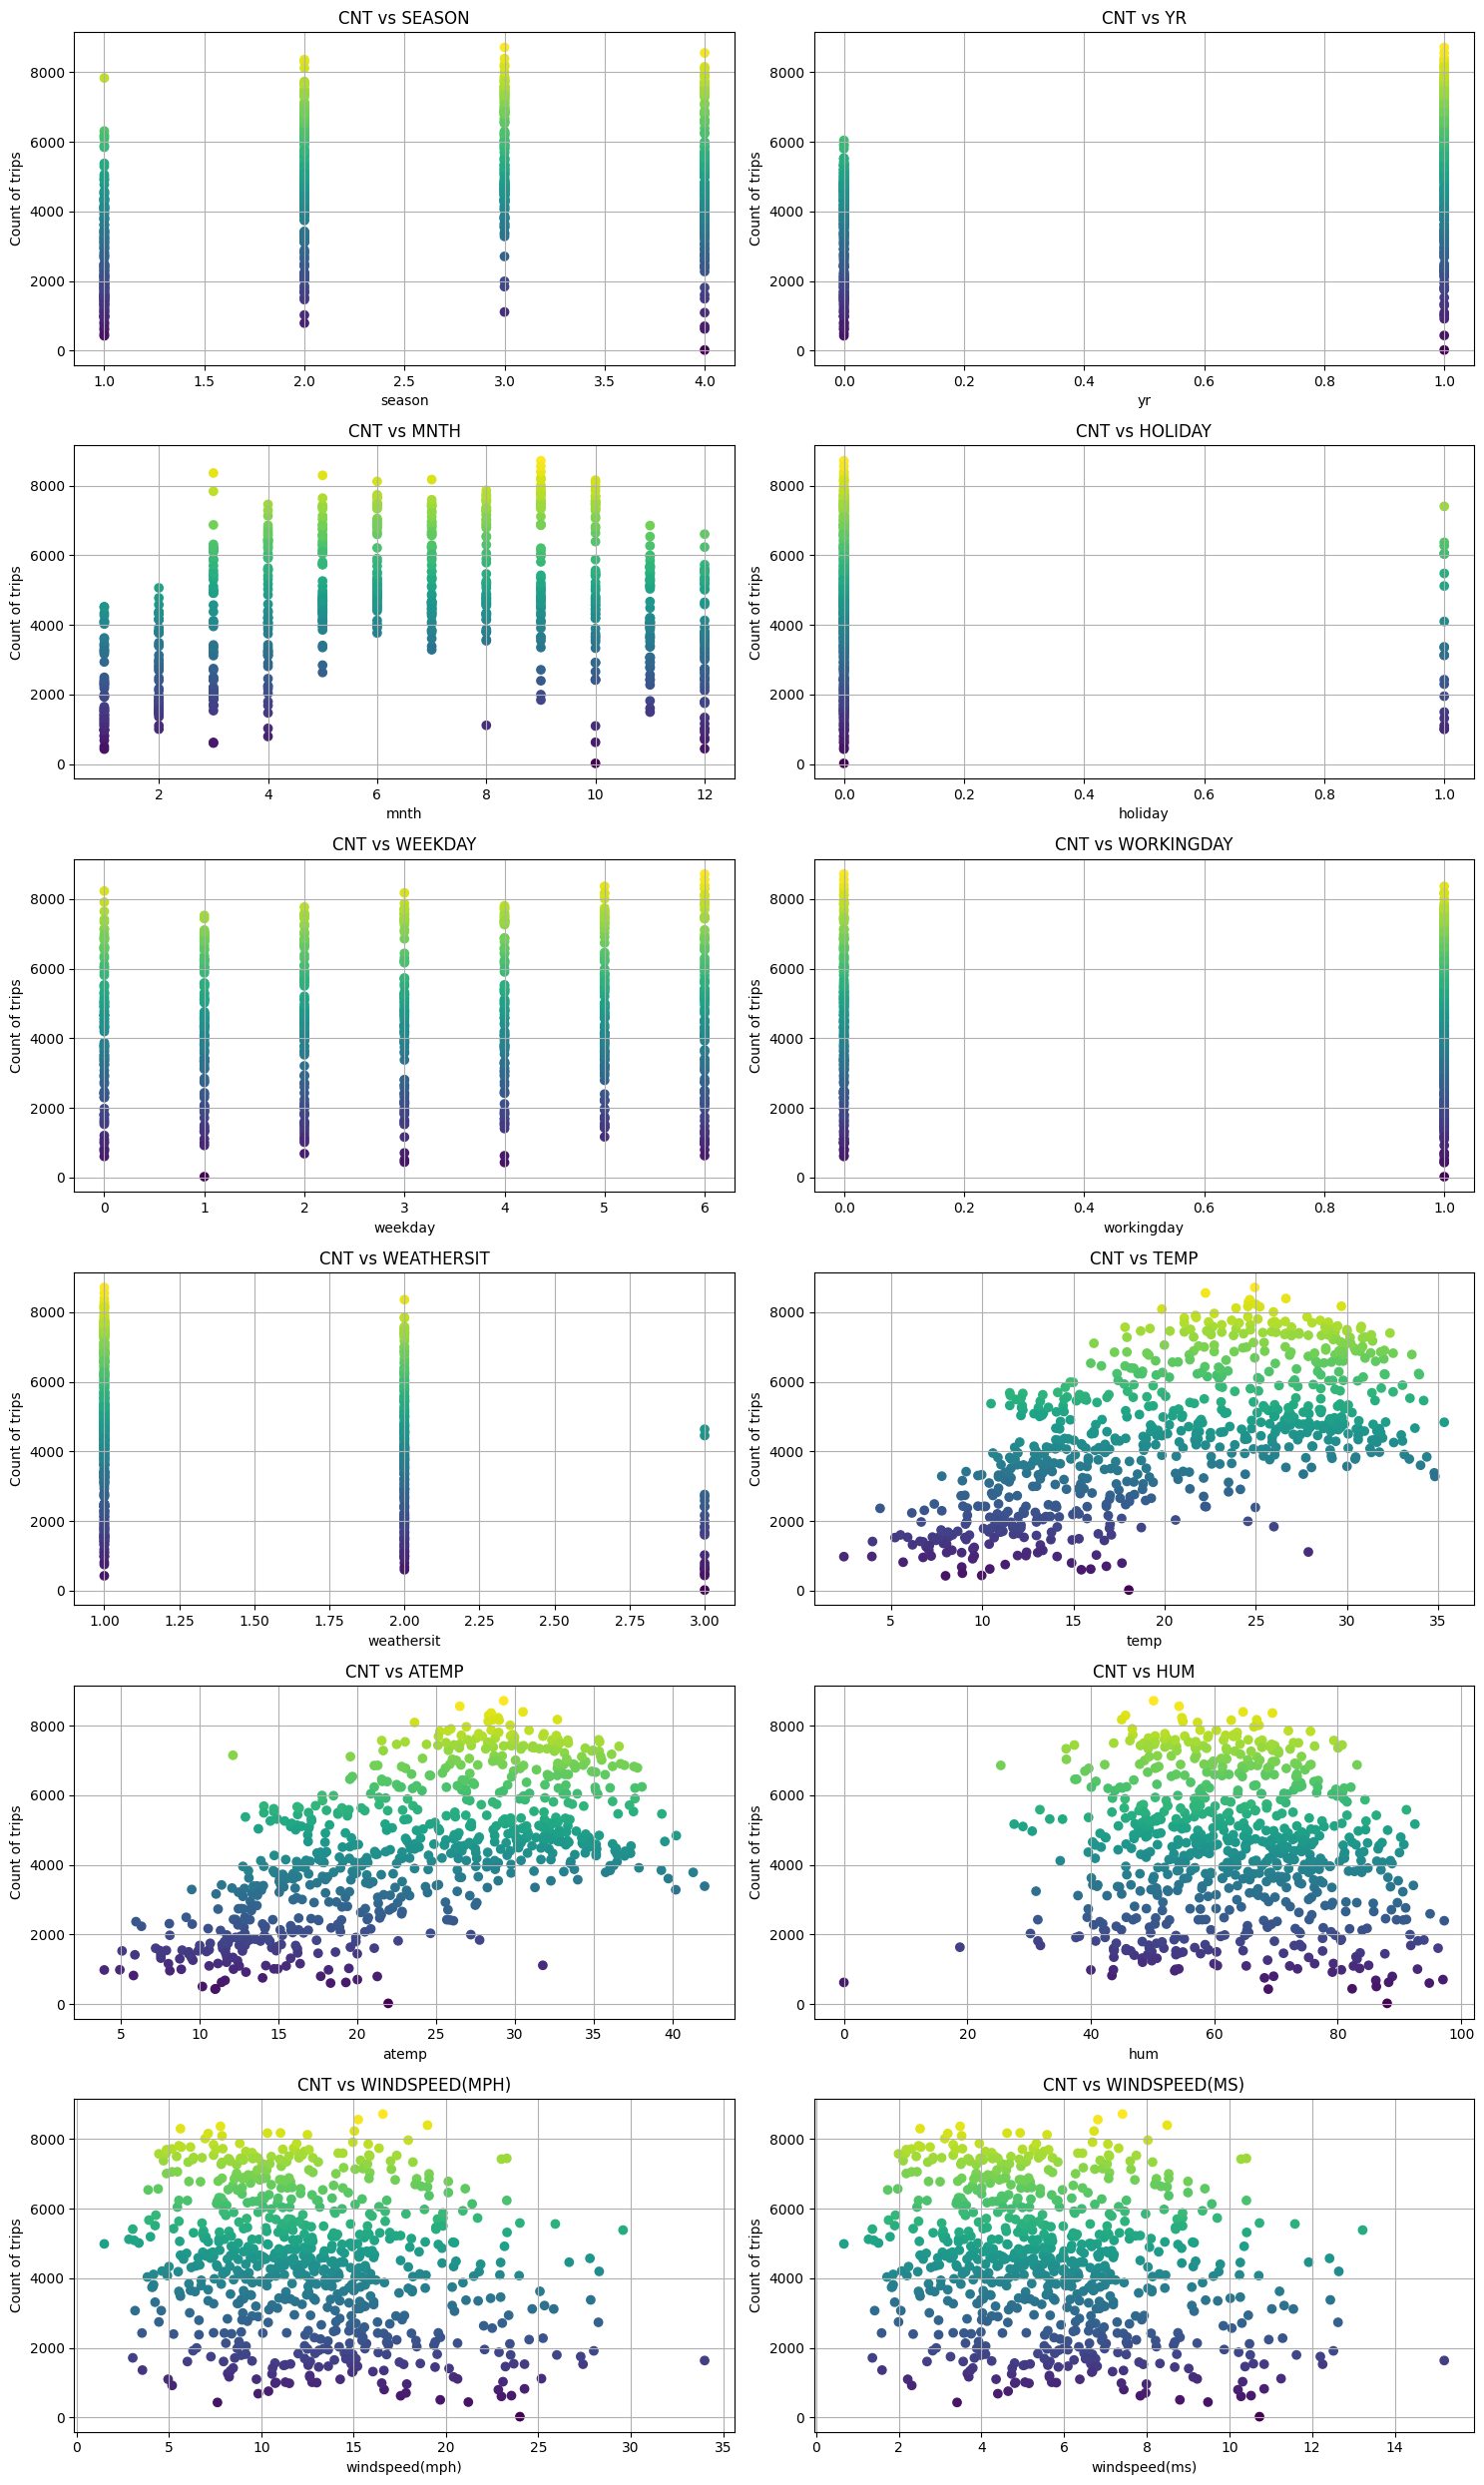

In [771]:
attributes = df.columns.tolist()[:-1]

num_cols = 2
num_rows = 6

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 25))

for row in range(num_rows):
    for col in range(num_cols):
        attribute = attributes[row * num_cols + col]
        axs[row, col].set_title(f"CNT vs {attribute.upper()}")
        axs[row, col].set_xlabel(attribute)
        axs[row, col].set_ylabel("Count of trips")
        axs[row, col].grid(True)
        axs[row, col].scatter(
            df[attribute], df["cnt"], alpha=1, 
            # cmap="coolwarm", 
            c=df["cnt"]
        )

plt.tight_layout()
plt.show()

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.

#### **Відповідь:**

1. Кількість прокатів має сезонний характер. Графік залежності схожий на параболу: 

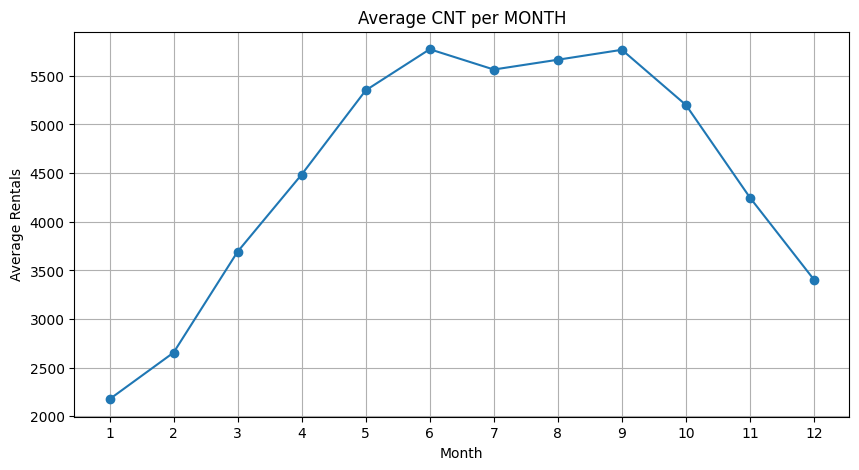

In [772]:
monthly_rent = df.groupby("mnth")["cnt"].mean()

plt.figure(figsize=(10, 5))
plt.plot(monthly_rent.index, monthly_rent.values, marker="o")
plt.title("Average CNT per MONTH")
plt.xlabel("Month")
plt.ylabel("Average Rentals")
plt.xticks(monthly_rent.index)
plt.grid(True)
plt.show()

2. Залежність схожа на лінійну для атрибутів: 
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [773]:
df[attributes].corr()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
season,1.000000,-0.001844,0.831440,-0.010537,-0.003080,0.012485,0.019211,0.334315,0.342876,0.205445,-0.229046,-0.229046
yr,-0.001844,1.000000,-0.001792,0.007954,-0.005461,-0.002013,-0.048727,0.047604,0.046106,-0.110651,-0.011817,-0.011817
mnth,0.831440,-0.001792,1.000000,0.019191,0.009509,-0.005901,0.043528,0.220205,0.227459,0.222204,-0.207502,-0.207502
holiday,-0.010537,0.007954,0.019191,1.000000,-0.101960,-0.253023,-0.034627,-0.028556,-0.032507,-0.015937,0.006292,0.006292
weekday,-0.003080,-0.005461,0.009509,-0.101960,1.000000,0.035790,0.031087,-0.000170,-0.007537,-0.052232,0.014282,0.014282
workingday,0.012485,-0.002013,-0.005901,-0.253023,0.035790,1.000000,0.061200,0.052660,0.052182,0.024327,-0.018796,-0.018796
weathersit,0.019211,-0.048727,0.043528,-0.034627,0.031087,0.061200,1.000000,-0.120602,-0.121583,0.591045,0.039511,0.039511
temp,0.334315,0.047604,0.220205,-0.028556,-0.000170,0.052660,-0.120602,1.000000,0.991702,0.126963,-0.157944,-0.157944
atemp,0.342876,0.046106,0.227459,-0.032507,-0.007537,0.052182,-0.121583,0.991702,1.000000,0.139988,-0.183643,-0.183643
hum,0.205445,-0.110651,0.222204,-0.015937,-0.052232,0.024327,0.591045,0.126963,0.139988,1.000000,-0.248489,-0.248489


<Axes: >

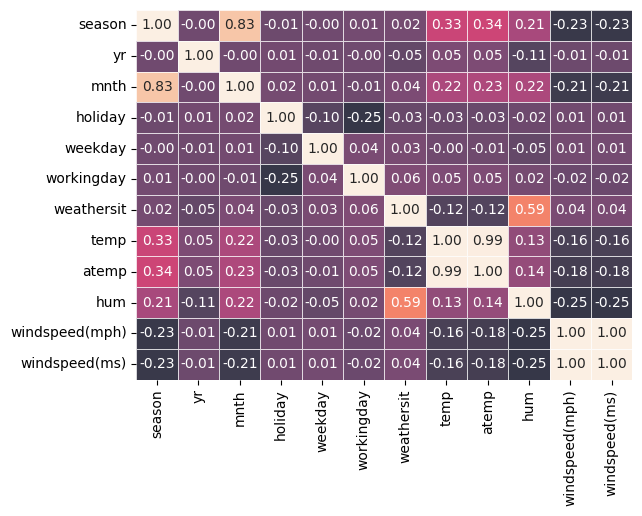

In [774]:
df_corr = df[attributes].corr()
sns.heatmap(df_corr, annot=True, linewidth=0.6, fmt=".2f", cbar=False, alpha=0.8)

In [775]:
df[attributes].corrwith(df["cnt"])

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [776]:
corr_features = ["temp", "atemp", "hum", "windspeed(mph)", "windspeed(ms)", "cnt"]
df[corr_features].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


<Axes: >

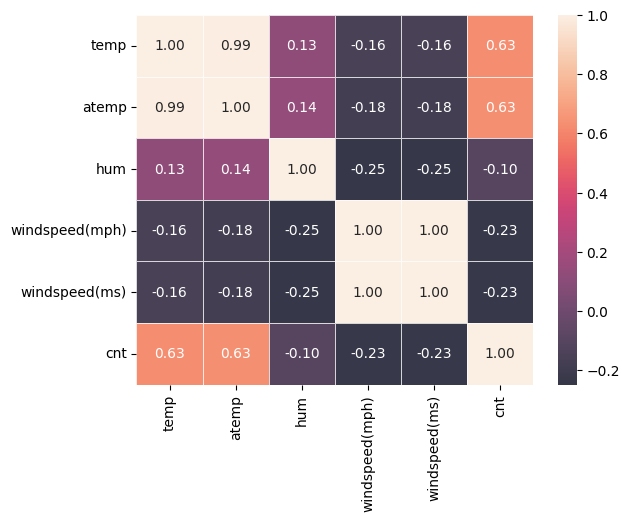

In [777]:
corr_features = ["temp", "atemp", "hum", "windspeed(mph)", "windspeed(ms)", "cnt"]
df_corr = df[corr_features].corr()
sns.heatmap(df_corr, annot=True, linewidth=0.6, fmt=".2f", cbar=True, alpha=0.8)

На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [778]:
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [779]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [780]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [781]:
from sklearn.linear_model import LinearRegression

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [782]:
model_LR = LinearRegression()

model_LR.fit(X, y)

for feature, weight in zip(df.columns[:-1], model_LR.coef_):
    print(f"{feature:15}", ":", weight)

season          : 570.863641661725
yr              : 1021.9604245185086
mnth            : -141.3006331900142
holiday         : -86.75760471139698
weekday         : 137.2272583151452
workingday      : 56.38980357474366
weathersit      : -330.2271825899341
temp            : 367.4799030832653
atemp           : 585.5521797658965
hum             : -145.6155228231448
windspeed(mph)  : 12454356291009.727
windspeed(ms)   : -12454356291208.188


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [783]:
from sklearn.linear_model import Lasso

model_LR_lasso = Lasso()
model_LR_lasso.fit(X, y)

for feature, weight in zip(df.columns[:-1], model_LR_lasso.coef_):
    print(f"{feature:15}", ":", weight)

season          : 560.2416160308861
yr              : 1019.4634940657196
mnth            : -128.73062703678696
holiday         : -86.15278133371106
weekday         : 137.34789390496314
workingday      : 55.21237064135668
weathersit      : -332.3698569623487
temp            : 376.3632362096943
atemp           : 576.530793504555
hum             : -144.12915500348583
windspeed(mph)  : -197.1396894024843
windspeed(ms)   : -2.8051404183533485e-08


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [784]:
from sklearn.linear_model import Ridge

model_LR_ridge = Ridge()
model_LR_ridge.fit(X, y)

for feature, weight in zip(df.columns[:-1], model_LR_ridge.coef_):
    print(f"{feature:15}", ":", weight)

season          : 563.0645722520164
yr              : 1018.9483787875275
mnth            : -131.87332028247582
holiday         : -86.74609799709243
weekday         : 138.00511117871926
workingday      : 55.90311037506429
weathersit      : -332.34978849907236
temp            : 386.45788919189926
atemp           : 566.3470470600766
hum             : -145.0713272986732
windspeed(mph)  : -99.25944108174306
windspeed(ms)   : -99.25944115438946


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [785]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    model_LR_lasso.set_params(alpha=alpha)
    model_LR_lasso.fit(X, y)
    coefs_lasso.append(model_LR_lasso.coef_)

    model_LR_ridge.set_params(alpha=alpha)
    model_LR_ridge.fit(X, y)
    coefs_ridge.append(model_LR_ridge.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

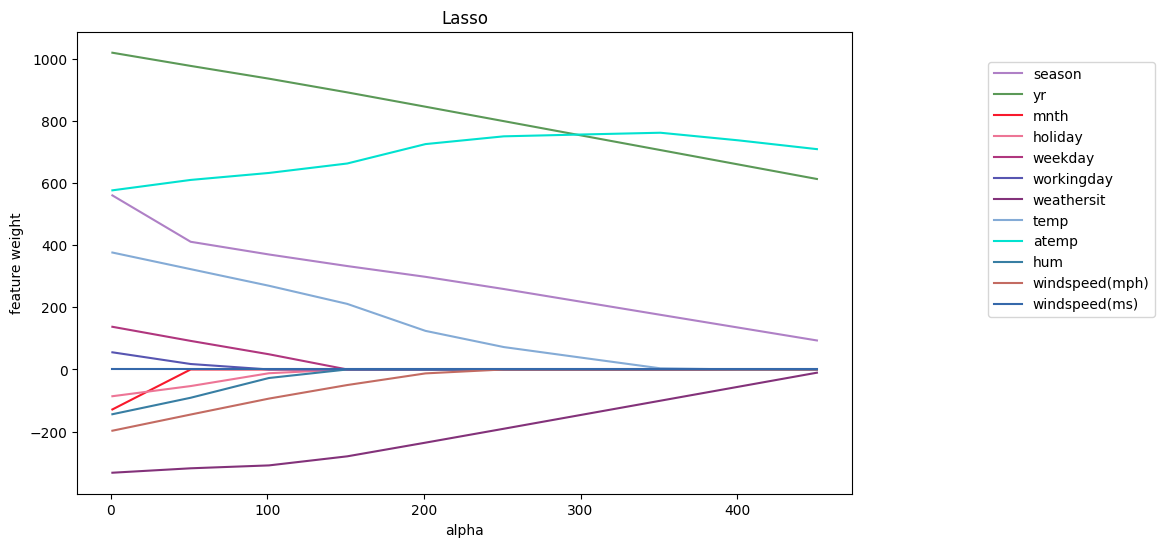

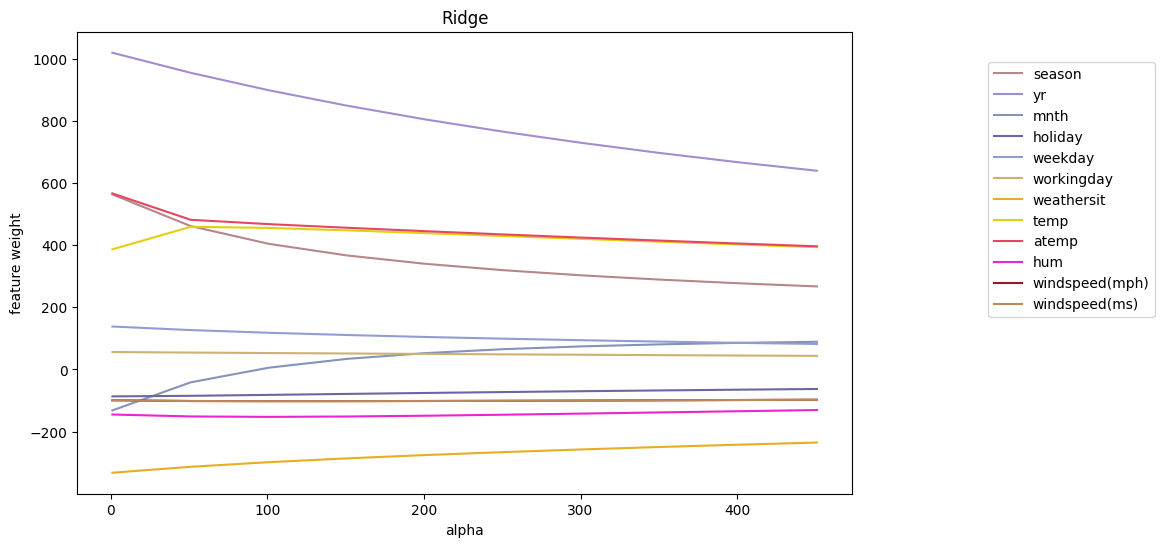

In [786]:
plt.figure(figsize=(10, 6))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(10, 6))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?

#### **Відповідь:**
1. Судячи з отриманих графіків можна стверджувати, що регуляризатор Lasso агресивніше зменшує ваги при одному й тому самому alpha.
2. Ми маємо тенденцію зниження до 0 значень вагів при збільшенні  показника alpha, отже якщо alpha зробити дуже великим, то ваги будуть майже нульовими.
3. Так, можна стверджувати, що Lasso виключає одну з ознак windspeed при будь-якому значенні alpha > 0. Це через те, що Lasso використовує L1-регуляризацію, яка спричиняє обнулення коефіцієнтів для деяких ознак. В тойже час, Ridge не виключає жодну з ознак. Ridge використовує L2-регуляризацію, яка зменшує величини коефіцієнтів, але не обнуляє їх повністю. Таким чином, навіть якщо значення коефіцієнту дуже мале, воно залишиться врахованим моделлю.
4. Для відбору неінформативних признаків Lasso є кращим вибором, оскільки він схильний встановлювати ваги нульовими.

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [787]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y, marker="x", color="b")

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

Alpha = 96, mse = 851990.7226862252
Alpha = 91, mse = 846392.1588364633
Alpha = 86, mse = 840822.7945299614
Alpha = 81, mse = 835574.3424234899
Alpha = 76, mse = 830286.629266498
Alpha = 71, mse = 825198.4820010145
Alpha = 66, mse = 820159.7018859921
Alpha = 61, mse = 815491.2384371456
Alpha = 56, mse = 811192.9043818455
Alpha = 51, mse = 807264.7026273535
Alpha = 46, mse = 803575.5866471968
Alpha = 41, mse = 800211.2474620756
Alpha = 36, mse = 797217.5699930101
Alpha = 31, mse = 794594.5606672271
Alpha = 26, mse = 792342.1957655506
Alpha = 21, mse = 789464.6632025437
Alpha = 16, mse = 786750.8408386442
Alpha = 11, mse = 783634.3772912038
Alpha = 6, mse = 781531.0908199241
Alpha = 1, mse = 785055.1467870021
Optimal alpha =  6


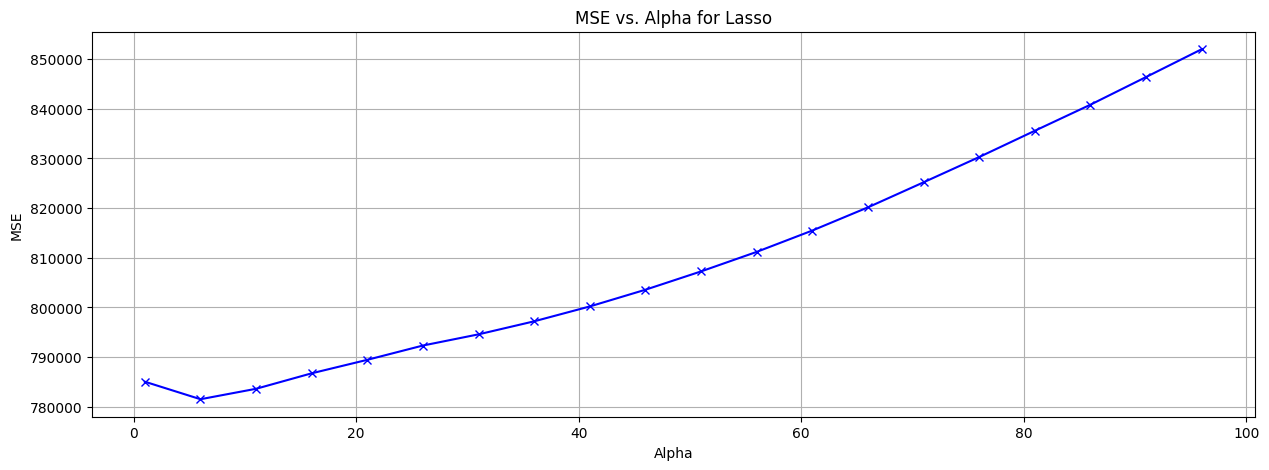

In [788]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=3)
regressor.fit(X, y)

mse_values = np.mean(regressor.mse_path_, axis=1)
data = list(zip(regressor.alphas_, mse_values))

# display(data)

for al, mse in data:
    print(f"Alpha = {al}, mse = {mse}")

print("Optimal alpha = ", regressor.alpha_)

create_plot(data, title="MSE vs. Alpha for Lasso", xlabel="Alpha", ylabel="MSE")

Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


Alphas with minimum MSE:
Alpha = 6, MSE = 733725.7604052245
Alpha = 1, MSE = 799433.1673691699
Alpha = 51, MSE = 796979.8955193633


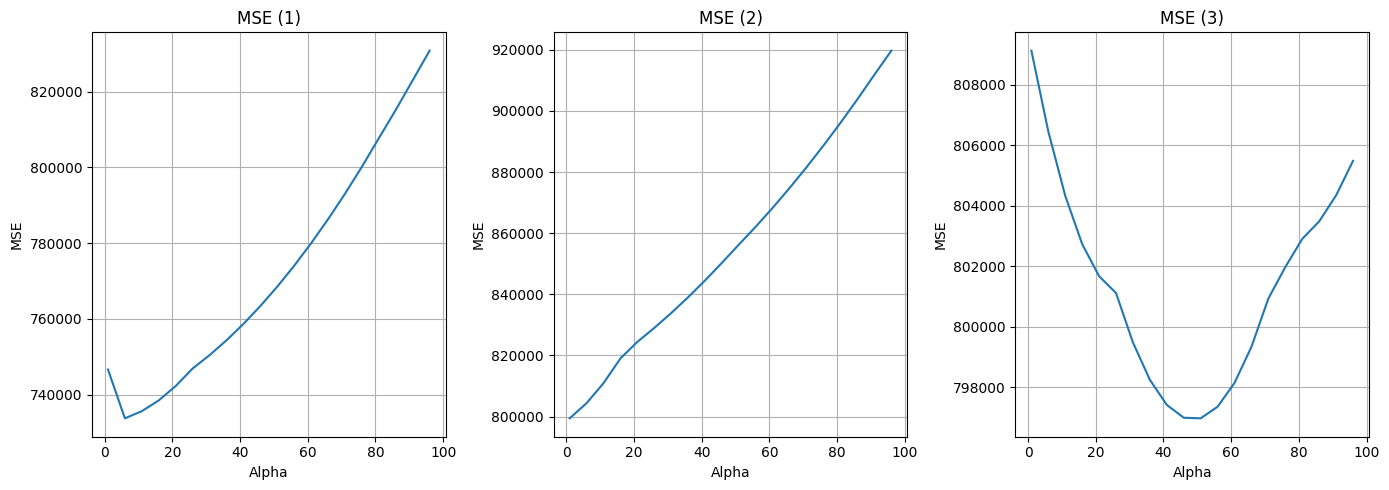

In [789]:
min_mse_values = np.min(regressor.mse_path_, axis=0)
alphas_equal_min_mse = regressor.alphas_[np.argmin(regressor.mse_path_, axis=0)]

print("Alphas with minimum MSE:")
for alpha, mse in zip(alphas_equal_min_mse, min_mse_values):
    print(f"Alpha = {alpha}, MSE = {mse}")

plt.figure(figsize=(14, 5))
for i in range(regressor.mse_path_.shape[1]):
    plt.subplot(1, 3, i + 1)
    plt.plot(regressor.alphas_, regressor.mse_path_[:, i])
    plt.title(f"MSE ({i+1})")
    plt.xlabel("Alpha")
    plt.ylabel("MSE")
    plt.grid()

plt.tight_layout()
plt.show()

На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

In [790]:
for feature, weight in sorted(
    zip(df.columns, regressor.coef_), key=lambda x: x[1], reverse=True
)[:4]:
    print(f"{feature:15}: {weight.round(2)}")

yr             : 1015.06
atemp          : 581.4
season         : 532.02
temp           : 370.68


Зростаюча лінійна залежність простежується. 
1. Для ознаки "yr" вона виглядає зростаючою тому що звітних періодів у нас тільки два, не обов'язково при збільшені року число прокатів збільшуватиметься.
2. Для ознаки "season" помітна закономірність, що сезон має сплив на кількість прокатів. Але зростання відбувається з січня по липень, з вересня починається сезонний спад. 
3. Для ознак "atemp" і "temp" лінійна залежність виражена досить чітко. Твердження, що чим більше значення ознаки, тим більше людей захочуть узяти велосипед, для даних ознак справедливе. Також, враховуючи, що ознаки "atemp" і "temp" залежать/пов'язані від ознаки "season", її теж можна брати до уваги.

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

In [791]:
for feature, weight in sorted(
    zip(df.columns, regressor.coef_), key=lambda x: x[1], reverse=True
)[-3:]:
    print(f"{feature:15}: {weight.round(2)}")

hum            : -140.01
windspeed(mph) : -191.77
weathersit     : -330.56


Так, простежується лінійна залежність, що зменшується. Так, можна стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди.

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

In [792]:
for feature, weight in zip(df.columns, regressor.coef_):
    if np.abs(weight) < 1e-2:
        print(f"{feature:15}: {weight}")

windspeed(ms)  : -2.6854702314758792e-08


1. Не суттєва кореляція з цільовою змінною.
2. Колінеарність з ознакою windspeed(mph).
Ці ознаки можуть впливати на попит велосипедів, але не суттєво.

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.